In [1]:
import pandas as pd
import numpy as np
import joblib 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit


# Fichiers
INPUT_FILE = "train_features_multisnapshot.parquet"
MODEL_FILE = "xgb_final_optimized.pkl"

print("✅ Librairies prêtes.")


✅ Librairies prêtes.


In [ ]:
# Chargement
df = pd.read_parquet(INPUT_FILE)
df = df.sort_values("snapshot_time").reset_index(drop=True)
print("📊 Dimensions :", df.shape)
print("📅 Période des snapshots :", df["snapshot_time"].min(), "→", df["snapshot_time"].max())


X = df.drop(columns=["userId", "target"])
cols_to_remove = ["last_ts", "registration_ts", "snapshot_time"]
X = X.drop(columns=[c for c in cols_to_remove if c in X.columns]) # because XGBoost cannot handle them
y = df["target"]

ratio = (y == 0).sum() / (y == 1).sum()
print(f"⚖️ Ratio de déséquilibre : {ratio:.2f}")


# -------------------------------
# 🔁 TimeSeriesSplit
# -------------------------------

tscv = TimeSeriesSplit(n_splits=5)

auc_scores = []
fold_preds = []
fold_trues = []

print("\n🚀 Entraînement avec TimeSeriesSplit...\n")

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):

    print(f"=== Fold {fold+1} ===")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Modèle identique à ton original
    model = XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=3,
        scale_pos_weight=ratio,
        eval_metric="auc",
        early_stopping_rounds=50,
        random_state=42,
        tree_method="hist"
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions validation
    preds_val = model.predict_proba(X_val)[:, 1]

    # AUC fold
    auc = roc_auc_score(y_val, preds_val)
    auc_scores.append(auc)

    fold_preds.append(preds_val)
    fold_trues.append(y_val.values)

    print(f"🎯 AUC fold {fold+1} : {auc:.4f}\n")

print(f"🔥 AUC moyenne TimeSeriesSplit = {np.mean(auc_scores):.4f}")


# # Split Stratifié (80% train, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # Calcul du déséquilibre (Combien de Non-Churners pour 1 Churner ?)
# # Cela va aider le modèle à "peser" ses erreurs.
# ratio = (y_train == 0).sum() / (y_train == 1).sum()
# print(f"Ratio de déséquilibre : {ratio:.2f}")



📊 Dimensions : (75863, 34)
📅 Période des snapshots : 2018-10-11 00:00:01 → 2018-11-08 00:00:01
⚖️ Ratio de déséquilibre : 18.39

🚀 Entraînement avec TimeSeriesSplit...

=== Fold 1 ===
🎯 AUC fold 1 : 0.7251

=== Fold 2 ===
🎯 AUC fold 2 : 0.7563

=== Fold 3 ===
🎯 AUC fold 3 : 0.7423

=== Fold 4 ===
🎯 AUC fold 4 : 0.7288

=== Fold 5 ===
🎯 AUC fold 5 : 0.7126

🔥 AUC moyenne TimeSeriesSplit = 0.7330


In [3]:
# print("🚀 Entraînement du modèle XGBoost...")

# xgb = XGBClassifier(
#     n_estimators=600,         # Nombre max d'arbres
#     learning_rate=0.03,       # Vitesse (lent = plus précis)
#     max_depth=4,              # Profondeur (4 est stable pour éviter l'overfitting)
#     scale_pos_weight=ratio,   # GESTION DU DÉSÉQUILIBRE (Très important !)
#     eval_metric="auc",        # Métrique interne
#     early_stopping_rounds=50, # Arrêt si le score stagne
#     random_state=42
# )

# # Entraînement avec validation en direct
# xgb.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     verbose=100
# )

# print("✅ Entraînement terminé.")


In [4]:
# -------------------------------
# 🎚️ Optimisation du seuil global
# -------------------------------

val_preds_all = np.concatenate(fold_preds)
val_true_all = np.concatenate(fold_trues)

thresholds = np.arange(0.01, 1.0, 0.01)
best_score, best_threshold = 0, 0.5

for t in thresholds:
    preds = (val_preds_all >= t).astype(int)
    score = balanced_accuracy_score(val_true_all, preds)
    if score > best_score:
        best_score = score
        best_threshold = t

print("\n🏆 Seuil optimal trouvé :")
print(f"   → Seuil : {best_threshold:.2f}")
print(f"   → Balanced Accuracy : {best_score:.4f}")




# print("🔍 Optimisation du seuil pour le Balanced Accuracy...")

# # Prédictions (probabilités) sur la validation
# y_proba = xgb.predict_proba(X_val)[:, 1]

# thresholds = np.arange(0.01, 1.0, 0.01)
# best_score = 0
# best_threshold = 0.5

# # On teste chaque seuil
# for t in thresholds:
#     preds = (y_proba >= t).astype(int)
#     score = balanced_accuracy_score(y_val, preds)
    
#     if score > best_score:
#         best_score = score
#         best_threshold = t

# print(f"\n🏆 RÉSULTAT OPTIMAL :")
# print(f"   Meilleur Seuil     : {best_threshold:.2f}")
# print(f"   Balanced Accuracy  : {best_score:.4f}")



🏆 Seuil optimal trouvé :
   → Seuil : 0.55
   → Balanced Accuracy : 0.6739


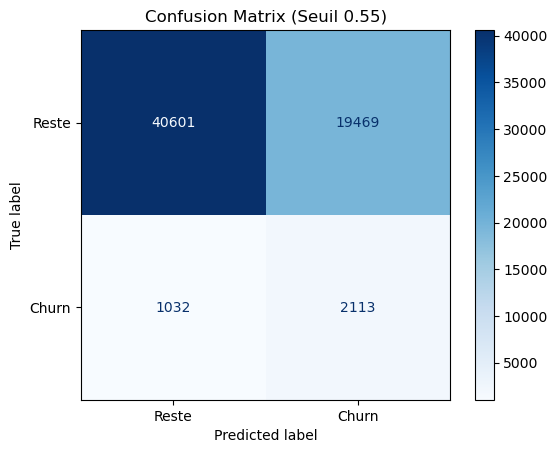

In [5]:
# -------------------------------
# 📊 Matrice de confusion globale
# -------------------------------

final_preds = (val_preds_all >= best_threshold).astype(int)
cm = confusion_matrix(val_true_all, final_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Churn"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Seuil {best_threshold})")
plt.show()




# # Matrice de confusion avec le meilleur seuil
# final_preds = (y_proba >= best_threshold).astype(int)
# cm = confusion_matrix(y_val, final_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reste", "Churn"])
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix (Seuil {best_threshold})")
# plt.show()

# # Importance des variables
# importances = pd.DataFrame({
#     'feature': X.columns,
#     'importance': xgb.feature_importances_
# }).sort_values('importance', ascending=False)

# print("🔝 Top 10 des features les plus importantes :")
# display(importances.head(10))


In [ ]:
# -------------------------------
# 🔥 Entraînement final du modèle
#    sur TOUT le dataset
# -------------------------------

print("\n🤖 Entraînement final du modèle sur tout le dataset...")

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=3,
    scale_pos_weight=ratio,
    eval_metric="auc",
    random_state=42,
    tree_method="hist"
)

xgb.fit(X, y)

# Importance des features
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 des features importantes :")
display(importances.head(10))


🤖 Entraînement final du modèle sur tout le dataset...

🔝 Top 10 des features importantes :


,feature,importance
7,Thumbs Down,0.233016
20,active_days_14d,0.151466
19,sessions_14d,0.097891
8,Roll Advert,0.052986
16,sessions_7d,0.052493
11,Downgrade,0.049765
13,satisfaction_ratio,0.028636
2,total_listening_time,0.026367
5,avg_daily_listen,0.024397
28,is_chrome,0.021341


In [7]:
# -------------------------------
# 💾 Sauvegarde du modèle
# -------------------------------

to_save = {
    "model": xgb,
    "threshold": best_threshold
}

joblib.dump(to_save, MODEL_FILE)

print(f"\n✅ Modèle final sauvegardé : {MODEL_FILE}")


# to_save = {
#     "model": xgb,
#     "threshold": best_threshold
# }
# joblib.dump(to_save, MODEL_FILE)
# print(f"✅ Modèle sauvegardé dans {MODEL_FILE}")


✅ Modèle final sauvegardé : xgb_final_optimized.pkl
